In [1]:
import os
from random import random
import pandas as pd
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim

root_path = 'data/transcriptions'
data_path = os.path.join(root_path,'train.csv')

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [ ]:
class Vocab:
    def __init__(self, counter,for_encoder=False, min_freq=None):
        
        self.sos = "<sos>"
        self.eos = "<eos>"
        self.pad = "<pad>"
        self.unk = "<unk>"
        
        self.pad_idx = 0
        self.unk_idx = 1
        self.sos_idx = 2
        self.eos_idx = 3
        
        if for_encoder:
            self._token2idx = {
                self.pad:self.pad_idx,
                self.unk:self.unk_idx,
            }
        else:
            self._token2idx = {
                self.sos: self.sos_idx,
                self.eos: self.eos_idx,
                self.pad: self.pad_idx,
                self.unk: self.unk_idx,
            }
        self._idx2token = {idx:token for token, idx in self._token2idx.items()}
        
        
        idx = len(self._token2idx)
        min_freq = 0 if min_freq is None else min_freq
        
        for token, count in counter.items():
            if count > min_freq:
                self._token2idx[token] = idx
                self._idx2token[idx]   = token
                idx += 1
        
        self.vocab_size = len(self._token2idx)
        self.tokens     = list(self._token2idx.keys())
    
    def token2idx(self, token):
        return self._token2idx.get(token, self.pad_idx)
    
    def idx2token(self, idx):
        return self._idx2token.get(idx, self.pad)
    
    def sent2idx(self, sent):
        return [self.token2idx(i) for i in sent]
    
    def idx2sent(self, idx):
        return [self.idx2token(i) for i in idx]
    
    def __len__(self):
        return len(self._token2idx)
    
    def __repr__(self):
        
        return '{}'.format(self._token2idx)

In [3]:
class CharactersDataset(Dataset):
    
    def __init__(self,csv_file_path,transform = None):
        self.file = pd.read_csv(csv_file_path,'r')
        self.transform = transform
        self.data = []
        self.characters_vocab = None
        self.transcripts_vocab = None
        self.non_needed_symbols = '\'#$?\\_({)}-:\";!%.1234567890'
        
        self.make_dataset()
       
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        
        x = self.data[idx]['x']
        y = self.data[idx]['y']
        data = {'x':x,'y':y}
        if self.transform:
            data = self.transform(data)
    
        return data
    
    def make_dataset(self):
        characters = set()
        transcripts = set()
        
        for idx in range(len(self.file)):
            item = str(self.file.iloc[idx][0]).split(',')
            
            x = item[1].strip()
            for symbol in self.non_needed_symbols:
                x = x.replace(symbol,'')
            if x == '':
                continue
            y = item[2].replace(' ','')
            self.data.append({'x':x,'y':y})
            for character in x:
                characters.add(character)
            for transcript in y:
                transcripts.add(transcript)
        
        self.characters_vocab = Vocab({v:k for k,v in dict(enumerate(characters,start=2)).items()},for_encoder=True)
        self.transcripts_vocab = Vocab({v:k for k,v in dict(enumerate(transcripts,start=4)).items()})
    
            
    def collate_fn(self, batch): 
        x_values     =  []
        x_lengths    =  []
        y_values_in  =  []
        y_values_out =  []
        
        for item in batch:
            
            x_values.append([self.characters_vocab.token2idx(ch) for ch in item['x']])
            y_values_in.append([self.transcripts_vocab.token2idx(tr) for tr in item['y']])
            y_values_out.append([self.transcripts_vocab.token2idx(tr) for tr in item['y']])
            
        sorted_tuples = sorted(zip(x_values,y_values_in,y_values_out),key=lambda x:len(x[0]),reverse=True)
        x_values     =  [l[0] for l in sorted_tuples]
        y_values_in  =  [l[1] for l in sorted_tuples]
        y_values_out =  [l[2] for l in sorted_tuples]
        
        max_x = len(x_values[0])
        max_y = max(len(l) for l in y_values_in)
            
        for word_index in range(len(x_values)):
            length_of_current_x = len(x_values[word_index])
            length_of_current_y = len(y_values_in[word_index])

            x_lengths.append(length_of_current_x)
            y_values_out[word_index].append(3)
            
            for _ in range(max_x - length_of_current_x):
                x_values[word_index].append(0)
            for _ in range(max_y - length_of_current_y):
                y_values_in[word_index].append(0)
                y_values_out[word_index].append(0)
            
            y_values_in[word_index].insert(0,2)
            
        y_values_in_tensor = torch.tensor(y_values_in)
        x_values_tensor     = torch.tensor(x_values)
        y_values_out_tensor = torch.tensor(y_values_out)
        
        return x_values_tensor,x_lengths,y_values_in_tensor,y_values_out_tensor

In [4]:
dataset = CharactersDataset(data_path)


dataset_size = len(dataset)
indices      = list(range(dataset_size))
valid_size   = int(np.floor(0.2 * dataset_size))
test_size    = valid_size + int(np.floor(0.05 * dataset_size))
np.random.shuffle(indices)

val_indices, test_indeces,train_indices = indices[:valid_size], indices[valid_size:test_size],indices[test_size:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indeces)



train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, 
                                           sampler=train_sampler,collate_fn = dataset.collate_fn)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                                sampler=valid_sampler,collate_fn = dataset.collate_fn)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                                sampler=test_sampler,collate_fn = dataset.collate_fn)

In [5]:
class EncoderLSTM(nn.Module):
    def __init__(self,embed_dim,hidden_size,output_size,n_layers = 1,dropout=0):
        super(EncoderLSTM,self).__init__()
        
        self.embedding = nn.Embedding(output_size,embed_dim,padding_idx = 0)
        self.LSTM = nn.LSTM(embed_dim,hidden_size,n_layers,dropout=(0 if n_layers == 1 else dropout),batch_first=True)
    
    def forward(self,input_seq,input_lengths,hidden=None):
        
        embedded = self.embedding(input_seq)
        
        packed = nn.utils.rnn.pack_padded_sequence(embedded,input_lengths,batch_first=True)
        
        outputs,hidden = self.LSTM(packed)
        
        outputs,_ = nn.utils.rnn.pad_packed_sequence(outputs,batch_first=True)
        return outputs,hidden

In [6]:
class AttentionDecoderLSTM(nn.Module):
    
    def __init__(self,embed_dim,hidden_size,output_size,n_layers=1,dropout=0):
        super(AttentionDecoderLSTM,self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        #layers
        self.embedding = nn.Embedding(output_size,embed_dim, padding_idx = 0)
        self.LSTM = nn.LSTM(embed_dim,hidden_size,n_layers,dropout = (0 if n_layers == 1 else self.dropout),batch_first=True)
        self.concat = nn.Linear(hidden_size*2,hidden_size)
        self.out = nn.Linear(hidden_size,output_size)
        
        
    def forward(self,input_step,last_hidden,encoder_outputs):
        #encoder_outputs.shape (batch_size,encoder_seq_len,hidden_dim)
        
        #input_step (batch_size)
        input_step = input_step.unsqueeze(1)
        #(batch_size,1)
        embedded = self.embedding(input_step)
        #embedded(batch_size,1,hidden_dim)
        
     
        
        decoder_outputs,hidden = self.LSTM(embedded,last_hidden)
        #(batch_size,1,hidden_dim)
        #seq_len = 1 if we using teacher forcing
        
        at_weights = decoder_outputs.bmm(encoder_outputs.transpose(1,2))
        #(batch_size,1,encoder_seq_len)
        
        at_weights = F.softmax(at_weights, dim=2)
        #(batch_size,1,encoder_seq_len)

        context = at_weights.bmm(encoder_outputs)
        #(batch_size,1,encoder_seq_len) * (batch_size,encoder_seq_len,hidden_dim)
        
        decoder_outputs = decoder_outputs.squeeze(1)
        context = context.squeeze(1)
        #(batch_size,hidden_dim)    #we deleated seq_len,which is = 1
        
        concat_input = torch.cat((decoder_outputs,context),1)
        #(batch_size,hidden_size*2)
        concat_output = torch.tanh(self.concat(concat_input))
        #(batch_size,hidden_size)
        predictions = self.out(concat_output)
        #(batch_size,output_dim)
        return predictions,hidden

In [7]:
BATCH_SIZE        = 32
HIDDEN_DIM        = 64
INPUT_VOCAB_SIZE  = len(dataset.characters_vocab)
OUTPUT_VOCAB_SIZE = len(dataset.transcripts_vocab)


encoder = EncoderLSTM(BATCH_SIZE,HIDDEN_DIM,INPUT_VOCAB_SIZE).to(device)
decoder = AttentionDecoderLSTM(BATCH_SIZE,HIDDEN_DIM,OUTPUT_VOCAB_SIZE,dropout=0.2).to(device)

In [8]:
import random
class seq2seq(nn.Module):
    def __init__(self,encoder,decoder,device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device  = device
    
    
    def forward(self,x,x_lengths,y,teacher_forcing_ratio = 1):
        
        encoder_outputs,last_hidden = self.encoder(x,x_lengths)
       
        
        batch_size         = y.shape[0]
        seq_len            = y.shape[1]
        output_vocab_size  = self.decoder.output_size
        predictions        = torch.zeros(batch_size,seq_len,output_vocab_size)
        
        input_token = y[:,0]
        
        for t in range(1,seq_len):
            
            decoder_output,last_hidden = self.decoder(input_token,last_hidden,encoder_outputs)
            predictions[:,t-1] = decoder_output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = decoder_output.max(1)[1]
            input_token = (y[:,t] if teacher_force else top1)
        
        decoder_output,last_hidden = self.decoder(input_token,last_hidden,encoder_outputs)
        predictions[:,t] = decoder_output
        
        return predictions
        
    def predict(self,x,x_lengths):
        
        #batch_size = 1!
        x.unsqueeze_(0)
        encoder_outputs,hidden = self.encoder(x,x_lengths)
        char_to_input = torch.LongTensor([2]).to(device)
        preds = []
        while True:
            
            predictions,hidden = self.decoder(char_to_input, hidden, encoder_outputs)
           
            index_of_next = torch.argmax(predictions,dim=1)
            our_value = index_of_next.item()
            if our_value == 3:
                break
            char_to_input = index_of_next
            preds.append(our_value)
            
        return preds                    
  

In [9]:
model = seq2seq(encoder,decoder,device)


def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = 0)

The model has 62,044 trainable parameters


In [10]:
def train(model, iterator, optimizer, criterion, clip,epoch,train_loss_list,teacher_forcing_ratio):
    
    model.train()
    
    epoch_loss = 0
    teacher_forcing_ratio = 1.0
    
    for i, batch in enumerate(iterator):
        
        x = batch[0].to(device)
        x_lengths = batch[1]
        y_in = batch[2].to(device)
        y_out = batch[3].to(device)
        
        optimizer.zero_grad()
        
        output = model(x,x_lengths, y_in,teacher_forcing_ratio)
        #output dim (y_seq_len,batch_size,output_dim)
        output = output.view(-1,output.shape[-1]).to(device)
        y_out = y_out.view(-1)
        loss = criterion(output, y_out)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        train_loss_list.append(loss.item())


    return epoch_loss / len(iterator)

In [11]:
def evaluate(model, iterator, criterion,validation_losses):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            x = batch[0].to(device)
            x_lengths = batch[1]
            y_in = batch[2].to(device)
            y_out = batch[3].to(device)
            
            output = model(x,x_lengths,y_in,0) #turn off teacher forcing
            
            output = output.view(-1,output.shape[-1]).to(device)
            y_out = y_out.view(-1)

            loss = criterion(output, y_out)
            
            epoch_loss += loss.item()
            validation_losses.append(loss.item())
    return epoch_loss / len(iterator)



In [12]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def plot(epoch, train_losses, val_losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('epoch %s. | loss: %s' % (epoch, np.mean(train_losses[-100:])))
    plt.plot(train_losses)
    plt.subplot(132)
    plt.title('epoch %s. | loss: %s' % (epoch, np.mean(val_losses[-100:])))
    plt.plot(val_losses)
    plt.show()

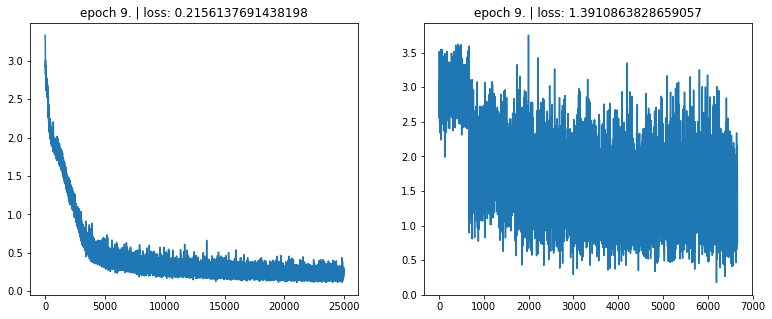

	Train Loss: 0.219 | Train PPL:   1.245
	Valid Loss: 1.433 | Valid PPL:   4.191


In [13]:
import math

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')
train_losses = []
validation_losses = []
teacher_forcing_ratio = 1.0

for epoch in range(N_EPOCHS):
    
    if epoch > 2:
        teacher_forcing_ratio = 0.3
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP,epoch,train_losses,teacher_forcing_ratio)
    valid_loss = evaluate(model, validation_loader, criterion,validation_losses)
    
    
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
        
    plot(epoch,train_losses,validation_losses)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid PPL: {math.exp(valid_loss):7.3f}')                                              

In [14]:
def predict_batch(model,batch,batch_size):
    x_tokens = []
    y_tokens_predicted = []
    y_tokens_true = []
    for i in range(batch_size):
        x_tokens.append(''.join([dataset.characters_vocab.idx2token(k.item()) for k in batch[0][i] if k.item() != 0]))
        y_pred = model.predict(batch[0][i].to(device),[batch[1][i]])
        y_tokens_predicted.append(''.join([dataset.transcripts_vocab.idx2token(k) for k in y_pred]))
        y_tokens_true.append(''.join([dataset.transcripts_vocab.idx2token(k.item()) for k in batch[2][i] if k.item() != 0 and k.item() != 2]))
    for i in range(len(x_tokens)):
        print('Input:',x_tokens[i])
        print('Predicted_output:',y_tokens_predicted[i])
        print('True output:',y_tokens_true[i],'\n\n')

In [17]:
for batch in test_loader:
    predict_batch(model,batch,32)
    break

Input: DELIBERATIONS
Predicted_output: DEHLAHBEREYSHAHNZ
True output: DIHLIHBEREYSHAHNZ 


Input: DICTIONARIES
Predicted_output: DIHKSHAHNERIYZ
True output: DIHKSHAHNEHRIYZ 


Input: MACINTOSHES
Predicted_output: MAESIHNTOWSHIHZ
True output: MAEKAHNTAOSHIHZ 


Input: ISLAMICALLY
Predicted_output: IHZLAHMIHKLIY
True output: IHZLAAMIHKLIY 


Input: VIEWFINDER
Predicted_output: VIYWAHMIHNDER
True output: VYUWFAYNDER 


Input: AFTERNOON
Predicted_output: AEFTERNUWN
True output: AEFTERNUWN 


Input: PROMSTERS
Predicted_output: PRAAMSTERZ
True output: PRAAMSTERZ 


Input: ENCRYPTED
Predicted_output: IHNKRIHPTIHD
True output: IHNKRIHPTIHD 


Input: MIDSUMMER
Predicted_output: MIHDSUWMER
True output: MIHDSAHMER 


Input: CRUMBLING
Predicted_output: KRAHMBLIHNG
True output: KRAHMBAHLIHNG 


Input: CORRECTED
Predicted_output: KEREHKTIHD
True output: KEREHKTIHD 


Input: CREELMAN
Predicted_output: KRIYLMAHN
True output: KRIYLMAHN 


Input: IMMOBILE
Predicted_output: IHMAHBAYL
True output: IHMOWBA